In [103]:
"""Sandbox module."""
import matplotlib.pyplot as plt
import numpy as np
import warnings

from fda_funcs import (
    compute_moments,
    compute_principal_components,
    compute_fpc_scores,
    mode_of_variation
)
from misc import (
    cdf_from_density,
    density_from_qd,
    l2_norm,
    norm_pdf,
    norm_cdf,
    quantile_from_cdf,
    riemann_sum_arrays,
    trunc_norm_pdf,
)
from scipy.stats import norm, truncnorm

%matplotlib inline

In [104]:
# Make the warning always appear
warnings.filterwarnings("always")

$\int_0^1 f(t)dt$  wird dann durch die Riemann Summe $1/m \sum_{j=1}^m f(s_j)$ ersetzt ($s_j$  - Gridpunkte, $m$ -  Anzahl der Gridpunkte).

# Functional Data Analysis

Ideas for simulation
- Uni- vs. Multivariate case
- Simulate different normal distributions
- Vary parameters of (generalized) Beta distribution, so principal components can be interpreted as varying parameters

$X(t) = \sum_{k=1}^n η_k φ_k(t)$


## Transformation Method Paper (Petersen & Müller 2016)

In [132]:
# 1. Generate synthetic functional data
n = 200
gridnum = 1000
truncation_point = 3
delta=1e-2

grid_densities = np.linspace(
    start=-truncation_point,
    stop=truncation_point,
    num=gridnum,
)
grid_quantiles = np.linspace(start=delta, stop=1-delta, num=gridnum)

# Draw different sigmas
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)

In [133]:
# Calculate discretized distributions, with different methods, to compare performance

# Calculate densities
a, b = (-truncation_point - mus) / sigmas, (truncation_point - mus) / sigmas
densities_discretized = norm_pdf(grid_densities[:,np.newaxis], mus, sigmas).transpose()
densities_discretized2 = truncnorm.pdf(
    x=grid_densities[:, np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
densities_discretized3 = trunc_norm_pdf(
    grid_densities[:, np.newaxis],
    mus,
    sigmas,
    -truncation_point,
    truncation_point,
).transpose()

# Calculate distribution functions
cdfs_discretized = cdf_from_density(
    grid_densities,
    densities_discretized,
    axis=1,
)
cdfs_discretized2 = cdf_from_density(
    grid_densities,
    densities_discretized2,
    axis=1,
)
cdfs_discretized3 = cdf_from_density(
    grid_densities,
    densities_discretized3,
    axis=1,
)

# Calculate quantiles
quantiles_discretized = norm.ppf(grid_quantiles[:, np.newaxis], mus, sigmas).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles[:, np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities[:, np.newaxis].transpose(),
    cdfs_discretized3,
    grid_quantiles,
)

# Calculate quantile densities
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

c:\Coding\frechet_fda\src\frechet_fda\misc.py:140: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.4872626704889901 
 In position: 40 
 Performing normalization...
  warnings.warn(


In [134]:
# Bugfixing
def dens_to_qd(density, x_support, qd_support):
    # Calculate cumulative density (CDF) using trapezoidal rule
    cdf = np.cumsum(density) * (x_support[-1] - x_support[0])
    
    # Transform to quantile density
    q_density = 1 / np.interp(qd_support, cdf, density)
    
    # Normalize
    q_density = q_density / np.trapz(q_density, qd_support)
    
    return q_density

tempi = np.zeros((n, gridnum))
for i in range(n):
    tempi[i,:] = dens_to_qd(densities_discretized3[i], grid_densities, grid_quantiles)
(tempi[0] - quantile_densities_discretized3[0])[1]

In [138]:
### Check whether my function differs from scipy func on first generated density sample
eps = 1e-2
(
    (abs(densities_discretized[0] - densities_discretized2[0]) > eps).sum(),
    (abs(cdfs_discretized[0] - cdfs_discretized2[0]) > eps).sum(),
    (abs(quantiles_discretized[0] - quantiles_discretized2[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized[0] - quantile_densities_discretized2[0])
        > eps
    ).sum(),
    (abs(densities_discretized2[0] - densities_discretized3[0]) > eps).sum(),
    (abs(cdfs_discretized2[0] - cdfs_discretized3[0]) > eps).sum(),
    (abs(quantiles_discretized2[0] - quantiles_discretized3[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized2[0] - quantile_densities_discretized3[0])
        > eps
    ).sum(),
)

(0, 0, 0, 0, 0, 0, 0, 184)

### Check how fast the different implementations are.

1. My normal distribution functions
2. Scipy's Truncated normals
3. My truncated normals

(For quantiles always used scipy's implementation of ppf.)

In [140]:
%%timeit
densities_discretized = norm_pdf(grid_densities[:,np.newaxis], mus, sigmas).transpose()
quantiles_discretized = norm.ppf(grid_quantiles[:,np.newaxis], mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()

37.3 ms ± 864 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [141]:
%%timeit
densities_discretized2 = truncnorm.pdf(
    x=grid_densities[:,np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles[:,np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()

191 ms ± 5.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [142]:
%%timeit
densities_discretized3 = trunc_norm_pdf(grid_densities[:,np.newaxis], mus, sigmas, a, b).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities[:,np.newaxis].transpose(),
    cdfs_discretized,
    grid_quantiles,
)
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

46.3 ms ± 516 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3rd approach faster than scipys
Less accurate with quantiles though. Gets better with higher grid size, but wont do more
than 1000 for computational cost

### Use implementation 3, faster than scipy but still correct

In [143]:
ds_discretized = densities_discretized3
cs_discretized = cdfs_discretized3
qs_discretized = quantiles_discretized3
qds_discretized = quantile_densities_discretized3

## Compare my discretized cdf to analytical cdf from scipy, to see whether S shape is there

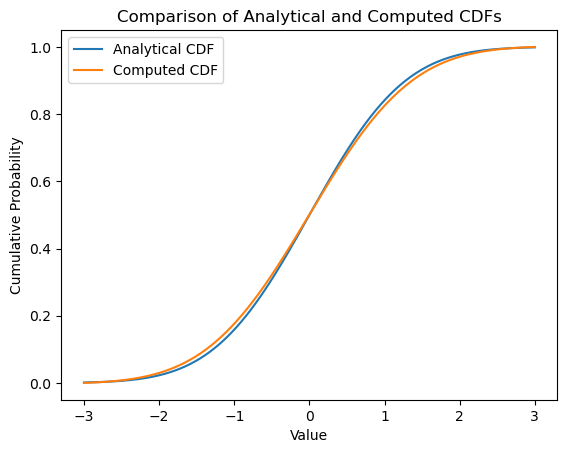

In [144]:
# Analytical CDF for standard normal distribution
analytical_cdf = norm.cdf(grid_densities)

# Plot
plt.plot(grid_densities, analytical_cdf, label="Analytical CDF")
plt.plot(
    grid_densities,
    cs_discretized[14],
    label="Computed CDF",
)  # Adjust index as needed
plt.legend()
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Analytical and Computed CDFs")
plt.show()

## Perform FPCA

In [145]:
# Compute moments to work with in FPCA
mean_function, centered_densities, cov_matrix = compute_moments(ds_discretized)

In [146]:
# Compute the eigenfunctions (principal components) of the covariance matrix
eigenvalues, eigenfunctions = compute_principal_components(cov_matrix, grid_densities)

In [147]:
# Compute FPC scores / factor loadings
fpc_scores = compute_fpc_scores(centered_densities, eigenfunctions, grid_densities)

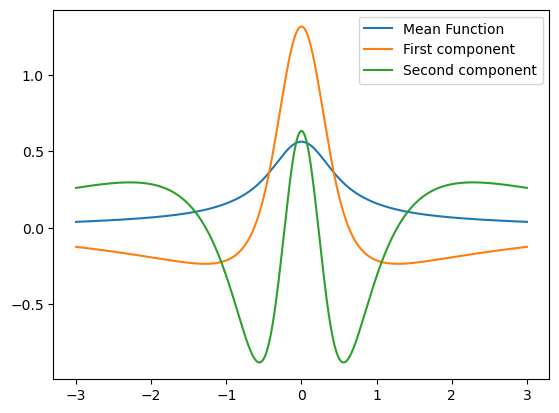

In [148]:
# Plot the mean function and the first two eigenfunctions
fig, ax = plt.subplots()
ax.plot(grid_densities, mean_function, label="Mean Function")
ax.plot(grid_densities, eigenfunctions[:, 0], label="First component")
ax.plot(grid_densities, eigenfunctions[:, 1], label="Second component")
plt.legend()
plt.show()

## More reproducing of Petersen & Müller (2016)

In [149]:
# Compute first two modes of variation
first_two_modes = mode_of_variation(
    mean_function,
    eigenvalues[:2],
    eigenfunctions[:, :2],
    1
)

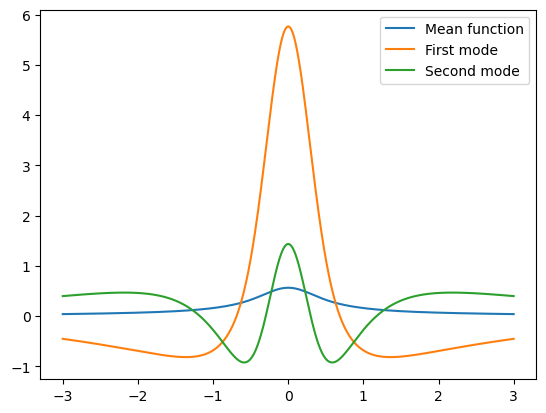

In [150]:
fig, ax = plt.subplots()
ax.plot(grid_densities, mean_function, label="Mean function")
ax.plot(grid_densities, first_two_modes[:, 0], label="First mode")
ax.plot(grid_densities, first_two_modes[:, 1], label="Second mode")
plt.legend()
plt.show()

## Fréchet mean estimation

In [155]:
def wasserstein_frechet_mean(qds_discretized, qs_discretized, grid, qdsup=None):
    """Compute Wasserstein-Fréchet mean from sample."""
    mean_qdf = np.mean(qds_discretized, axis=0)
    start_quantile = np.mean(qs_discretized[:, 0])
    return density_from_qd(mean_qdf, start_quantile, grid, qdsup)

In [157]:
def density_from_qd(qd, start_quantile, dsup, qdsup=None):
    """Compute density from a quantile density function.

    'Inspired' from qd2dens in fdadensity package in R.

    """
    if qdsup is None:
        qdsup = np.linspace(0.2, 1, len(qd))
    quantile_oplus = start_quantile  + riemann_sum_arrays(
        support_grid=qdsup, array=qd, axis=0, cumsum=True
    )

    dens_temp = 1 / qd
    ind = np.unique(quantile_oplus, return_index=True)[1]
    quantile_oplus = np.atleast_1d(quantile_oplus)[ind]
    dens_temp = dens_temp[~ind]
    dens = np.interp(dsup, quantile_oplus, dens_temp)
    dens /= riemann_sum_arrays(dsup, dens, axis=0, cumsum=False)

    return dens, quantile_oplus

In [158]:
f_oplus, quantile_oplus = wasserstein_frechet_mean(
    qds_discretized,
    qs_discretized, 
    grid_densities,
    grid_quantiles
)
F_oplus = cdf_from_density(
    grid_densities,
    f_oplus,
    axis=0,
)
F_oplus[-1]

1.0

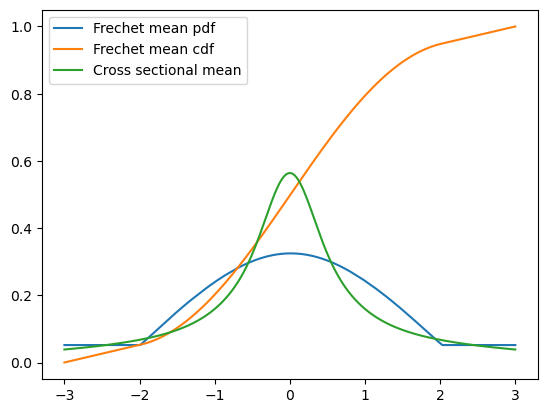

In [159]:
fig, ax = plt.subplots()
ax.plot(grid_densities, f_oplus, label="Frechet mean pdf")
ax.plot(grid_densities, F_oplus, label="Frechet mean cdf")
ax.plot(grid_densities, mean_function, label="Cross sectional mean")
plt.legend()
plt.show()

In [127]:
mean_qdf = np.mean(qds_discretized, axis=0)
mean_qf = np.mean(qs_discretized, axis=0)

In [128]:
lim = 999
mean_qdf[lim], riemann_sum_arrays(grid_quantiles[:lim], array=mean_qdf[:lim], axis=0, cumsum=True).max()

(12689101052855.81, 2.122453363633255e+30)

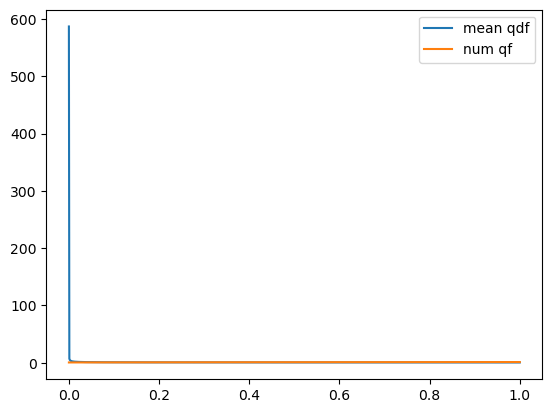

In [129]:
mqdf = np.mean(tempi, axis=0)
fig, ax = plt.subplots()
ax.plot(grid_quantiles, mqdf, label="mean qdf")
ax.plot(grid_quantiles, riemann_sum_arrays(grid_quantiles, array=mqdf, axis=0, cumsum=True), label="num qf")
# ax.plot(grid_quantiles, mean_qf, label="analytical qf")
plt.legend()
plt.show()

In [130]:
def fve(k):
    """Compute explained variance."""
    return np.sum(eigenvalues[:k]) / np.sum(eigenvalues)


fve(1), fve(2)

(0.8790804571454471, 0.9855911290852558)

NameError: name 'grid_densities_univ' is not defined

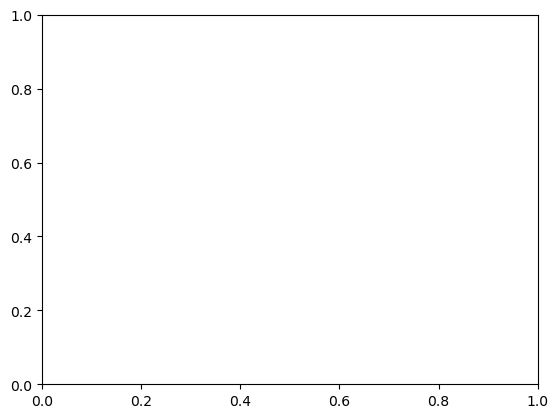

In [131]:
fig, ax = plt.subplots()
# for i in range(3):
#     j = i + 39
#     ax.plot(grid_densities_univ, ds_discretized[j], label=f"Density {j}")
ax.plot(grid_densities_univ, ds_discretized[40], label=f"Density {40}")
ax.plot(grid_densities_univ, mean_function, label="mean pdf")
ax.plot(grid_densities_univ, f_oplus, label="wf mean")
# ax.plot(grid_quantiles_univ, mean_qf[0] + riemann_sum_arrays(grid_quantiles_univ, array=mean_qdf, axis=0, cumsum=True), label="qf")
plt.legend()
plt.show()